In [1]:
#Importing packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate, Flatten
from keras import regularizers

# Unrotated Dataset

In [2]:
mol_num = 1750 #Defining number of molecules
atom_num = 3 #Defining number of atoms
coords_num = 3 #Defining number of coordinates

#Selecting which lines to read from the file
specified_lines = []
for i in range(mol_num): #Looping over the number of molecules in the dataset
    specified_lines.append(2 + 5*i) #Selecting the first Hydrogen atom
    specified_lines.append(3 + 5*i) #Selecting the Oxygen atom
    specified_lines.append(4 + 5*i) #Selecting the second Hydrogen atom

H2O_unrot_pos = open('H2O_unrotated.xyz') #Opening the coordinates file
atomic_coordinates_unrot = np.zeros((mol_num*atom_num,coords_num)) #Array to store atomic coordinates in
#Extracting the atomic coordinates from the file
for line, data in enumerate(H2O_unrot_pos): #Looping over the lines of the data file
    if line in specified_lines: #Selecting a line to read
        atomic_coordinates_unrot[specified_lines.index(line)] = np.array(list(map(float, data.split()[1:1 + coords_num]))) #Adding the atomic coordinates into the array
#Grouping the atomic coordinates according to the molecule number
molecular_coordinates_unrot = np.zeros((mol_num,atom_num,coords_num)) #Array to store molecular coordinates in
for i in range(mol_num): #Looping over the number of molecules
    temp = np.zeros((atom_num,coords_num)) #Creating temporary array
    for j in range(atom_num): #Looping over the number of atoms in a molecule
        temp[j] = atomic_coordinates_unrot[(3*i)+j] #Adding all coordinates of a single molecule to the temporary array
    molecular_coordinates_unrot[i] = temp #Adding the coordinates for each molecule to the array

H2O_unrot_ens = open('H2O_unrotated.ener') #Opening the energies file
molecular_energies_unrot = np.zeros(mol_num) #Array to store the molecular energies
#Storing the energy values in an array
for line, data in enumerate(H2O_unrot_ens): #Looping over the lines in the data file
    molecular_energies_unrot[line] = float(data.split()[0]) #Adding the energy value to the array

In [3]:
mol_features_unrot = np.zeros((mol_num,atom_num)) #Array to store features in
for i in range(len(molecular_coordinates_unrot)): #Looping over the molecules
    H_O = molecular_coordinates_unrot[i][0] - molecular_coordinates_unrot[i][1] #Calculating distance vector between first Hydrogen and Oxygen
    O_H = molecular_coordinates_unrot[i][1] - molecular_coordinates_unrot[i][2] #Calculating distance vector between Oxygen and second Hydrogen
    H_H = molecular_coordinates_unrot[i][0] - molecular_coordinates_unrot[i][2] #Calculating distance vector between two Hydrogens
    r_H_O = np.sqrt(np.dot(H_O, H_O)) #Calculating distance value between first Hydrogen and Oxygen
    r_O_H = np.sqrt(np.dot(O_H, O_H)) #Calculating distance value between Oxygen and second Hydrogen
    r_H_H = np.sqrt(np.dot(H_H, H_H)) #Calculating distance value between Hydrogens
    mol_features_unrot[i] = np.array([r_H_O, r_O_H, r_H_H]) #Adding distances to the array

In [4]:
#Normalising the input data
norm_mol_features_unrot = np.zeros(mol_features_unrot.shape) #Array to store the normalised atomic distances in 
for i in range(len(mol_features_unrot[0])): #Looping over the number atoms in each molecule
    #Normalising the atomic distances
    norm_mol_features_unrot[:,i] = (mol_features_unrot[:,i] - np.min(mol_features_unrot[:,i]))/(np.max(mol_features_unrot[:,i]) - np.min(mol_features_unrot[:,i]))

#Normalising the molecular energies
norm_mol_energies_unrot = (molecular_energies_unrot - np.min(molecular_energies_unrot))/(np.max(molecular_energies_unrot) - np.min(molecular_energies_unrot))

In [5]:
#Turning the data into tensors
training_input_unrot_tensor = tf.convert_to_tensor(norm_mol_features_unrot)
training_output_unrot_tensor = tf.convert_to_tensor(norm_mol_energies_unrot)

In [6]:
test_mol_num = 250 #Defining the total number of molecules in the test set
H2O_test_pos = open('H2O_test.xyz') #Opening the coordinates file
atomic_coordinates_test = np.zeros((test_mol_num*atom_num,coords_num)) #Array to store atomic coordinates in
#Extracting the atomic coordinates from the file
for line, data in enumerate(H2O_test_pos): #Looping over the lines in the data file
    if line in specified_lines: #Selecting a line from the data file
        atomic_coordinates_test[specified_lines.index(line)] = np.array(list(map(float, data.split()[1:4]))) #Adding the coordinates of each atom into the array
molecular_coordinates_test = np.zeros((test_mol_num,atom_num,coords_num)) #Array to store molecular coordinates in
#Grouping the atomic coordinates according to the molecule number
for i in range(test_mol_num): #Looping over the number of molecules
    temp = np.zeros((atom_num,coords_num)) #Creating temporary array
    for j in range(atom_num): #Looping over number of atoms in a molecule
        temp[j] = atomic_coordinates_test[(3*i)+j] #Adding the coordinates of each atom in a molecule to the array
    molecular_coordinates_test[i] = temp #Adding the array of coordinates of the atoms in a single molecule to the molecular array

H2O_test_ens = open('H2O_test.ener') #Opening the energies file
molecular_energies_test = np.zeros(test_mol_num) #Array to store the molecular energies
#Storing the energy values in an array
for line, data in enumerate(H2O_test_ens): #Looping over the lines in the data file
    molecular_energies_test[line] = float(data.split()[0]) #Adding the energy value to the array

mol_features_test = np.zeros((test_mol_num,atom_num)) #Array to store features in
for i in range(len(molecular_coordinates_test)): #Looping over the molecules
    H_O = molecular_coordinates_test[i][0] - molecular_coordinates_test[i][1] #Calculating distance vector between first Hydrogen and Oxygen
    O_H = molecular_coordinates_test[i][1] - molecular_coordinates_test[i][2] #Calculating distance vector between Oxygen and second Hydrogen
    H_H = molecular_coordinates_test[i][0] - molecular_coordinates_test[i][2] #Calculating distance vector between two Hydrogens
    r_H_O = np.sqrt(np.dot(H_O, H_O)) #Calculating distance value between first Hydrogen and Oxygen
    r_O_H = np.sqrt(np.dot(O_H, O_H)) #Calculating distance value between Oxygen and second Hydrogen
    r_H_H = np.sqrt(np.dot(H_H, H_H)) #Calculating distance valye between Hydrogens
    mol_features_test[i] = np.array([r_H_O, r_O_H, r_H_H]) #Adding distances to the array

In [7]:
#Normalizing the test data
norm_mol_features_test = np.zeros(mol_features_test.shape) #Array to store the normalised atomic distances in 
for i in range(len(mol_features_test[0])): #Looping over the number atoms in each molecule
    #Normalising the atomic distances
    norm_mol_features_test[:,i] = (mol_features_test[:,i] - np.min(mol_features_test[:,i]))/(np.max(mol_features_test[:,i]) - np.min(mol_features_test[:,i]))

#Normalising the molecular energies
norm_mol_energies_test = (molecular_energies_test - np.min(molecular_energies_test))/(np.max(molecular_energies_test) - np.min(molecular_energies_test))

In [8]:
#Converting the array data types to TensorFlow tensors
test_input = tf.convert_to_tensor(norm_mol_features_test) #Creating the test input tensor
test_output = tf.convert_to_tensor(norm_mol_energies_test) #Creating the test output tensor

In [9]:
#Creating machine learning model
model_unrot = Sequential()
model_unrot.add(Input(shape=(atom_num,)))
model_unrot.add(Flatten(input_shape=(mol_num,atom_num)))
model_unrot.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
model_unrot.add(Dense(12, activation = 'relu', kernel_regularizer=regularizers.l1(1e-4), bias_regularizer=regularizers.l1(1e-4)))
model_unrot.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
model_unrot.add(Dense(1,))

model_unrot.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model_unrot.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dense_2 (Dense)             (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 253 (1012.00 Byte)
Trainable params: 253 (1012.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
epoch_num = 500 #Setting the number of epochs
#Training the model and calculating the loss
history_unrot = model_unrot.fit(training_input_unrot_tensor,training_output_unrot_tensor, epochs = epoch_num, validation_split = 0.2, shuffle = True)
training_loss_values_unrot = history_unrot.history['loss'] #Calculating the training loss
validation_loss_values_unrot = history_unrot.history['val_loss'] #Calculating the validation loss

Epoch 1/500


44/44 [==============================] - 1s 6ms/step - loss: 0.0362 - accuracy: 7.1429e-04 - val_loss: 0.0238 - val_accuracy: 0.0000e+00
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 7.1429e-04 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 7.1429e-04 - val_loss: 0.0183 - val_accuracy: 0.0000e+00
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 7.1429e-04 - val_loss: 0.0158 - val_accuracy: 0.0000e+00
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 7.1429e-04 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.0014 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 7/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.0014 - val_los

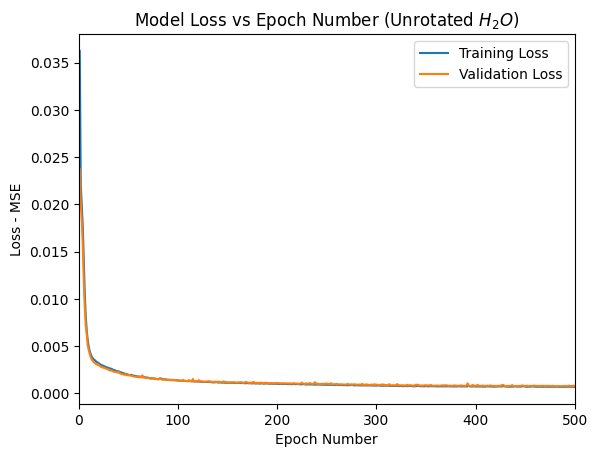

In [11]:
#Plotting the training and validation loss vs the epoch number
epoch_values = np.linspace(1,epoch_num,epoch_num)
plt.title('Model Loss vs Epoch Number (Unrotated $H_2O$)')
plt.xlim([0,epoch_num])
plt.xlabel('Epoch Number')
plt.ylabel('Loss - MSE')
plt.plot(epoch_values, training_loss_values_unrot, label = 'Training Loss')
plt.plot(epoch_values, validation_loss_values_unrot, label = 'Validation Loss')
plt.legend(loc='upper right')

In [12]:
#Calculating the predicted energy values
norm_predictions_unrot = model_unrot.predict(test_input) #Calculating normalised predicted energy values
predictions_unrot = norm_predictions_unrot*(np.max(molecular_energies_unrot) - np.min(molecular_energies_unrot)) + np.min(molecular_energies_unrot)

8/8 [==============================] - 0s 1ms/step


The model MSE between predicted and test energy values is 0.005675305351629409


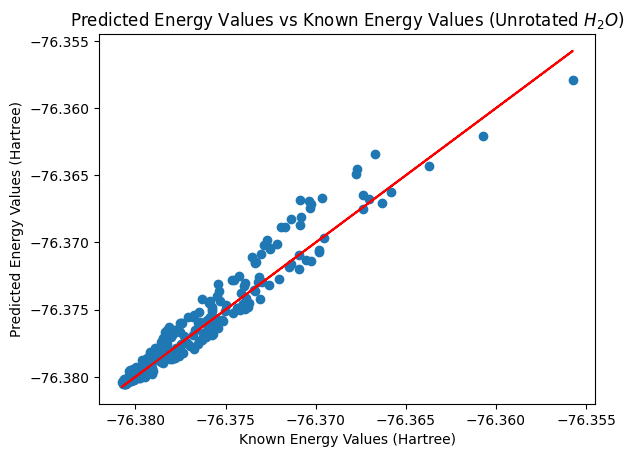

In [14]:
#Printing the final model loss
print(f"The model MSE between predicted and test energy values is {np.sqrt(np.mean((predictions_unrot-molecular_energies_test)**2))}")
#Plotting the real energy values vs the predicted energy values
plt.title('Predicted Energy Values vs Known Energy Values (Unrotated $H_2O$)')
plt.xlabel('Known Energy Values (Hartree)')
plt.ylabel('Predicted Energy Values (Hartree)')
plt.scatter(molecular_energies_test, predictions_unrot)
plt.plot(molecular_energies_test, molecular_energies_test, linestyle = '-', color = 'red')

In [ ]:
#Creating a list of possible training set sizes
training_sizes_unrot = np.linspace(len(training_input_unrot_tensor)*0.1,len(training_input_unrot_tensor),10,dtype=int)

N = 5 #Setting the number of calculations of the learning curve to average over
training_losses_unrot = np.zeros((N,len(training_sizes_unrot))) #Array to store training results from each run
test_losses_unrot = np.zeros((N,len(training_sizes_unrot))) #Array to store test results from each run
for i in range(N): #Calculating the learning curve N times
    training_loss_values_unrot2 = np.zeros(len(training_sizes_unrot)) #Array to store training loss in
    test_loss_values_unrot = np.zeros(len(training_sizes_unrot)) #Array to store test loss in
    
    for size in training_sizes_unrot: #Looping over training set sizes
        #Creating machine learning model
        model = Sequential()
        model.add(Input(shape=(atom_num,)))
        model.add(Flatten(input_shape=(mol_num,atom_num)))
        model.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
        model.add(Dense(12, activation = 'relu', kernel_regularizer=regularizers.l1(1e-4), bias_regularizer=regularizers.l1(1e-4)))
        model.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
        model.add(Dense(1,))
        
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        #Training the model
        history_unrot2 = model.fit(training_input_unrot_tensor,training_output_unrot_tensor, epochs = epoch_num, validation_split = 1-(size/len(training_input_unrot_tensor)), shuffle = True)
        training_loss_values_unrot2[np.where(training_sizes_unrot == size)] = history_unrot2.history['loss'][epoch_num-1] #Calculating training loss
        test_loss_values_unrot[np.where(training_sizes_unrot == size)] = model.evaluate(test_input, test_output)[0] #Calculating test loss

    training_losses_unrot[i] = training_loss_values_unrot2 #Storing training losses for the entire run
    test_losses_unrot[i] = test_loss_values_unrot #Storing test losses for the entire run

Epoch 1/500
6/6 [==============================] - 1s 37ms/step - loss: 0.1007 - accuracy: 0.0000e+00 - val_loss: 0.0706 - val_accuracy: 6.3452e-04
Epoch 2/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0656 - accuracy: 0.0000e+00 - val_loss: 0.0485 - val_accuracy: 6.3452e-04
Epoch 3/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0472 - accuracy: 0.0000e+00 - val_loss: 0.0377 - val_accuracy: 6.3452e-04
Epoch 4/500
6/6 [==============================] - 0s 14ms/step - loss: 0.0376 - accuracy: 0.0000e+00 - val_loss: 0.0325 - val_accuracy: 6.3452e-04
Epoch 5/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0329 - accuracy: 0.0000e+00 - val_loss: 0.0303 - val_accuracy: 6.3452e-04
Epoch 6/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0302 - accuracy: 0.0000e+00 - val_loss: 0.0294 - val_accuracy: 6.3452e-04
Epoch 7/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0290 - accuracy: 0.0000e+00 - val_loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



11/11 [==============================] - 0s 13ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0014
Epoch 421/500
11/11 [==============================] - 0s 12ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0014
Epoch 422/500
11/11 [==============================] - 0s 19ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0014
Epoch 423/500
11/11 [==============================] - 0s 11ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0014
Epoch 424/500
11/11 [==============================] - 0s 11ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0014
Epoch 425/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0014
Epoch 426/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



28/28 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.0023 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 489/500
28/28 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.0023 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 490/500
28/28 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.0023 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 491/500
28/28 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.0023 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 492/500
28/28 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.0023 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 493/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.0023 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 494/500
28/28 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.0023 - val_loss: 0.0013 - val_accura

In [25]:
#Averaging over calculations of the learning curve
training_loss_sum_unrot = np.zeros(len(training_sizes_unrot)) #Array to store sum of training results
test_loss_sum_unrot = np.zeros(len(training_sizes_unrot)) #Array to store sum of test results
for i in range(N): #Looping over calculations runs
    training_loss_sum_unrot += training_losses_unrot[i] #Summing together training results
    test_loss_sum_unrot += test_losses_unrot[i] #Summing together test results
training_loss_av_unrot = (1/N)*training_loss_sum_unrot #Dividing sums by repetition of calculation
test_loss_av_unrot = (1/N)*test_loss_sum_unrot #Dividing sums by repetition of calculation

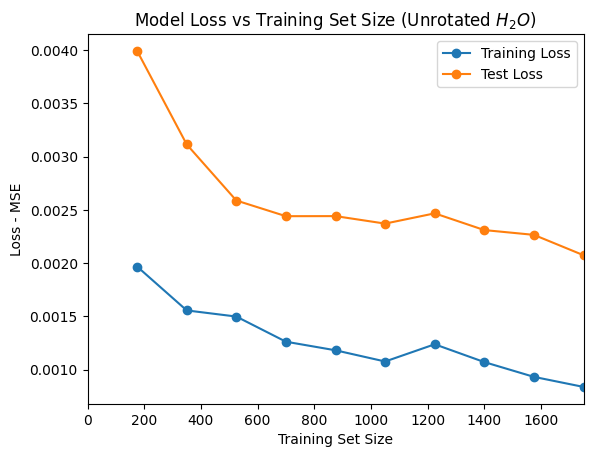

In [26]:
#Plotting training and test loss vs training set size
plt.title('Model Loss vs Training Set Size (Unrotated $H_2O$)')
plt.xlim([0,len(training_input_unrot_tensor)])
plt.xlabel('Training Set Size')
plt.ylabel('Loss - MSE')
plt.plot(training_sizes_unrot, training_loss_av_unrot, marker = 'o', label = 'Training Loss')
plt.plot(training_sizes_unrot, test_loss_av_unrot, marker = 'o', label = 'Test Loss')
plt.legend(loc='upper right')

# Rotated Dataset

In [15]:
H2O_rot_pos = open('H2O_rotated.xyz') #Opening the coordinates file
atomic_coordinates_rot = np.zeros((mol_num*atom_num,coords_num)) #Array to store atomic coordinates in
#Extracting the atomic symbols and coordinates from the file
for line, data in enumerate(H2O_rot_pos): #Looping over the lines in the data file
    if line in specified_lines: #Picking a line in the data file
        atomic_coordinates_rot[specified_lines.index(line)] = np.array(list(map(float, data.split()[1:1 + coords_num]))) #Adding the atomic coordinates to a list
molecular_coordinates_rot = np.zeros((mol_num,atom_num,coords_num)) #Array to store molecular coordinates in
#Grouping the atomic coordinates according to the molecule number
for i in range(mol_num): #Looping over the number of molecules
    temp = np.zeros((atom_num,coords_num)) #Creating temporary array
    for j in range(atom_num): #Looping over the number of atoms in a single molecule
        temp[j] = atomic_coordinates_rot[(3*i)+j] #Adding the coordinates of each atom to the temporary array
    molecular_coordinates_rot[i] = temp #Adding all coordinates of the atoms in a single molecule to the array

H2O_rot_ens = open('H2O_rotated.ener') #Opening the energies file
molecular_energies_rot = np.zeros(mol_num) #Array to store the molecular energies
#Storing the energy values in an array
for line, data in enumerate(H2O_rot_ens): #Looping over lines in the data file
    molecular_energies_rot[line] = float(data.split()[0]) #Adding the energy value to the array

In [16]:
mol_features_rot = np.zeros((mol_num,atom_num)) #Array to store features in
for i in range(len(molecular_coordinates_rot)): #Looping over the molecules
    H_O = molecular_coordinates_rot[i][0] - molecular_coordinates_rot[i][1] #Calculating distance vector between first Hydrogen and Oxygen
    O_H = molecular_coordinates_rot[i][1] - molecular_coordinates_rot[i][2] #Calculating distance vector between Oxygen and second Hydrogen
    H_H = molecular_coordinates_rot[i][0] - molecular_coordinates_rot[i][2] #Calculating distance vector between two Hydrogens
    r_H_O = np.sqrt(np.dot(H_O, H_O)) #Calculating distance value between first Hydrogen and Oxygen
    r_O_H = np.sqrt(np.dot(O_H, O_H)) #Calculating distance value between Oxygen and second Hydrogen
    r_H_H = np.sqrt(np.dot(H_H, H_H)) #Calculating distance valye between Hydrogens
    mol_features_rot[i] = np.array([r_H_O, r_O_H, r_H_H]) #Adding distances to list

In [17]:
#Normalising the input data
norm_mol_features_rot = np.zeros(mol_features_rot.shape) #Array to store the normalised atomic distances in 
for i in range(len(mol_features_rot[0])): #Looping over the number atoms in each molecule
    #Normalising the atomic distances
    norm_mol_features_rot[:,i] = (mol_features_rot[:,i] - np.min(mol_features_rot[:,i]))/(np.max(mol_features_rot[:,i]) - np.min(mol_features_rot[:,i]))

#Normalising the molecular energies
norm_mol_energies_rot = (molecular_energies_rot - np.min(molecular_energies_rot))/(np.max(molecular_energies_rot) - np.min(molecular_energies_rot))

In [18]:
#Turning the data into tensors
training_input_rot_tensor = tf.convert_to_tensor(norm_mol_features_rot)
training_output_rot_tensor = tf.convert_to_tensor(norm_mol_energies_rot)

In [19]:
#Creating machine learning model
model_rot = Sequential()
model_rot.add(Input(shape=(atom_num,)))
model_rot.add(Flatten(input_shape=(mol_num,atom_num)))
model_rot.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
model_rot.add(Dense(12, activation = 'relu', kernel_regularizer=regularizers.l1(1e-4), bias_regularizer=regularizers.l1(1e-4)))
model_rot.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
model_rot.add(Dense(1,))

model_rot.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model_rot.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 32        
                                                                 
 dense_5 (Dense)             (None, 12)                108       
                                                                 
 dense_6 (Dense)             (None, 8)                 104       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 253 (1012.00 Byte)
Trainable params: 253 (1012.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
#Training the model and calculating the loss
history_rot = model_rot.fit(training_input_rot_tensor,training_output_rot_tensor, epochs = epoch_num, validation_split = 0.2, shuffle = True)
training_loss_values_rot = history_rot.history['loss'] #Calculating training loss
validation_loss_values_rot = history_rot.history['val_loss'] #Calculating validation loss

Epoch 1/500
44/44 [==============================] - 1s 4ms/step - loss: 0.0262 - accuracy: 7.1429e-04 - val_loss: 0.0225 - val_accuracy: 0.0000e+00
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 7.1429e-04 - val_loss: 0.0181 - val_accuracy: 0.0000e+00
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 7.1429e-04 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 7.1429e-04 - val_loss: 0.0096 - val_accuracy: 0.0000e+00
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.0014 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.0014 - val_loss: 0.0063 - val_accuracy: 0.0000e+00
Epoch 7/500
44/44 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.0014 - val_loss: 0.0

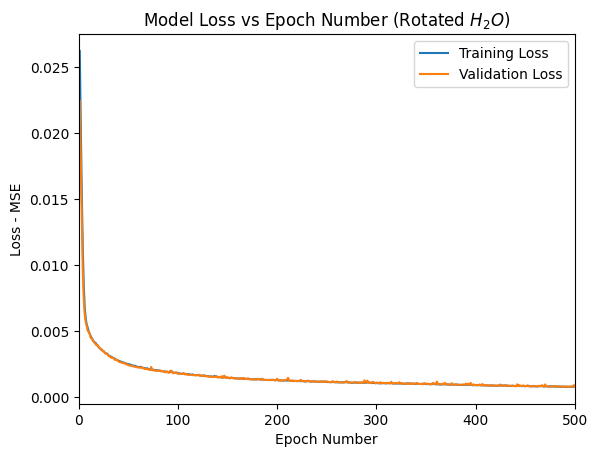

In [21]:
#Plotting the training and validation loss vs the epoch number
plt.title('Model Loss vs Epoch Number (Rotated $H_2O$)')
plt.xlim([0,epoch_num])
plt.xlabel('Epoch Number')
plt.ylabel('Loss - MSE')
plt.plot(epoch_values, training_loss_values_rot, label = 'Training Loss')
plt.plot(epoch_values, validation_loss_values_rot, label = 'Validation Loss')
plt.legend(loc='upper right')

In [22]:
#Calculating the predicted energy values
norm_predictions_rot = model_rot.predict(test_input) #Calculating normalised predicted energy values
predictions_rot = norm_predictions_rot*(np.max(molecular_energies_rot) - np.min(molecular_energies_rot)) + np.min(molecular_energies_rot)

8/8 [==============================] - 0s 925us/step


The MSE between the predicted and test energy values is 0.005600178421942583


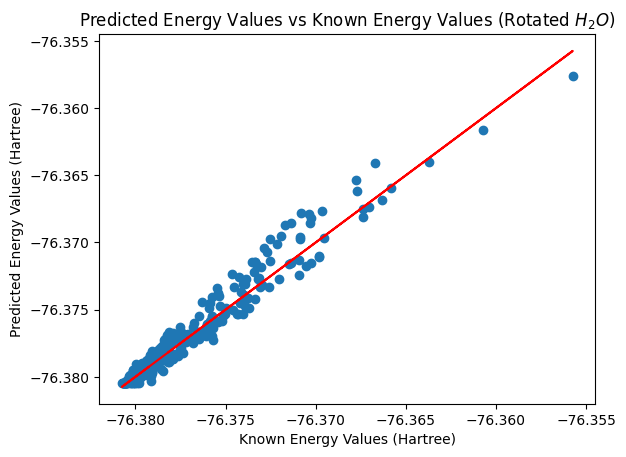

In [23]:
#Printing the final loss of the model
print(f"The MSE between the predicted and test energy values is {np.sqrt(np.mean((predictions_rot-molecular_energies_test)**2))}")
#Plotting the real energy values vs the predicted energy values
plt.title('Predicted Energy Values vs Known Energy Values (Rotated $H_2O$)')
plt.xlabel('Known Energy Values (Hartree)')
plt.ylabel('Predicted Energy Values (Hartree)')
plt.scatter(molecular_energies_test, predictions_rot)
plt.plot(molecular_energies_test, molecular_energies_test, linestyle = '-', color = 'red')

In [ ]:
#Creating a list of possible training set sizes
training_sizes_rot = np.linspace(len(training_input_rot_tensor)*0.1,len(training_input_rot_tensor),10,dtype=int)

N = 5
training_losses_rot = np.zeros((N,len(training_sizes_rot))) #Array to store all training results in
test_losses_rot = np.zeros((N,len(training_sizes_rot))) #Array to store all test results in
for i in range(N): #Repeating the process N times
    training_loss_values_rot2 = np.zeros(len(training_sizes_rot)) #Array to store training loss values in
    test_loss_values_rot = np.zeros(len(training_sizes_rot)) #Array to store test loss values in
    
    for size in training_sizes_rot: #Looping over training set sizes
        #Creating machine learning model
        model = Sequential()
        model.add(Input(shape=(atom_num,)))
        model.add(Flatten(input_shape=(mol_num,atom_num)))
        model.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
        model.add(Dense(12, activation = 'relu', kernel_regularizer=regularizers.l1(1e-4), bias_regularizer=regularizers.l1(1e-4)))
        model.add(Dense(8, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))
        model.add(Dense(1,))
        
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
        #Training the model
        history_unrot2 = model.fit(training_input_rot_tensor,training_output_rot_tensor, epochs = epoch_num, validation_split = 1-(size/len(training_input_rot_tensor)), shuffle = True)
        training_loss_values_rot2[np.where(training_sizes_rot == size)] = history_unrot2.history['loss'][epoch_num-1] #Calculating the training loss
        test_loss_values_rot[np.where(training_sizes_rot == size)] = model.evaluate(test_input, test_output)[0] #Calculating the test loss

    training_losses_rot[i] = training_loss_values_rot2 #Storing training results from run
    test_losses_rot[i] = test_loss_values_rot #Storing test results from run

Epoch 1/500
6/6 [==============================] - 1s 39ms/step - loss: 0.0548 - accuracy: 0.0000e+00 - val_loss: 0.0464 - val_accuracy: 6.3452e-04
Epoch 2/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0423 - accuracy: 0.0000e+00 - val_loss: 0.0374 - val_accuracy: 6.3452e-04
Epoch 3/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0367 - accuracy: 0.0000e+00 - val_loss: 0.0341 - val_accuracy: 6.3452e-04
Epoch 4/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0347 - accuracy: 0.0000e+00 - val_loss: 0.0318 - val_accuracy: 6.3452e-04
Epoch 5/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0327 - accuracy: 0.0000e+00 - val_loss: 0.0295 - val_accuracy: 6.3452e-04
Epoch 6/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0304 - accuracy: 0.0000e+00 - val_loss: 0.0278 - val_accuracy: 6.3452e-04
Epoch 7/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0287 - accuracy: 0.0000e+00 - val_loss

In [28]:
#Averaging over calculations of the learning curve
training_loss_sum_rot = np.zeros(len(training_sizes_rot)) #Array to store sum of training results
test_loss_sum_rot = np.zeros(len(training_sizes_rot)) #Array to store sum of test results
for i in range(N): #Looping over repetitions of calculation
    training_loss_sum_rot += training_losses_rot[i] #Summing together training results
    test_loss_sum_rot += test_losses_rot[i] #Summing together test results
training_loss_av_rot = (1/N)*training_loss_sum_rot #Dividing by repetition of calculation
test_loss_av_rot = (1/N)*test_loss_sum_rot #Dividing by repetition of calculation

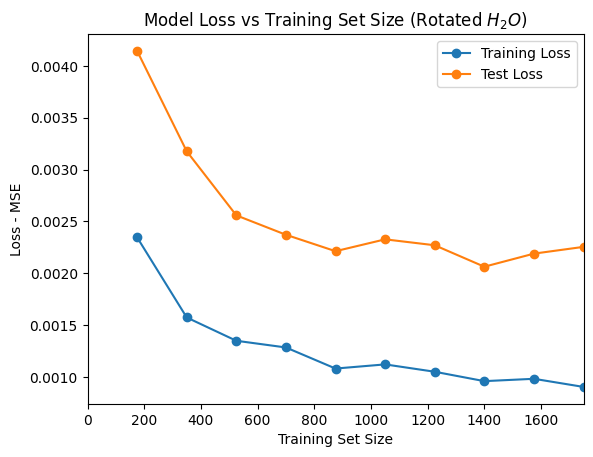

In [29]:
#Plotting the training and test loss vs the sizes of the training set 
plt.title('Model Loss vs Training Set Size (Rotated $H_2O$)')
plt.xlim([0,len(training_input_rot_tensor)])
plt.xlabel('Training Set Size')
plt.ylabel('Loss - MSE')
plt.plot(training_sizes_rot, training_loss_av_rot, marker = 'o', label = 'Training Loss')
plt.plot(training_sizes_rot, test_loss_av_rot, marker = 'o', label = 'Test Loss')
plt.legend(loc='upper right')